<a href="https://colab.research.google.com/github/ruchithareddy269/cmpe_257_Week-6_Assignment/blob/main/257_Assignment6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving California_Housing_Final_Dataset.csv to California_Housing_Final_Dataset.csv


In [ ]:
import pandas as pd
# Load the dataset
file_path = 'California_Housing_Final_Dataset.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset and its summary statistics to understand its structure
data.head(), data.describe()

(   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
 0    -122.23     37.88                  41          880           129.0   
 1    -122.22     37.86                  21         7099          1106.0   
 2    -122.24     37.85                  52         1467           190.0   
 3    -122.25     37.85                  52         1274           235.0   
 4    -122.25     37.85                  52         1627           280.0   
 
    population  households  median_income  median_house_value ocean_proximity  \
 0         322         126         8.3252              452600        NEAR BAY   
 1        2401        1138         8.3014              358500        NEAR BAY   
 2         496         177         7.2574              352100        NEAR BAY   
 3         558         219         5.6431              341300        NEAR BAY   
 4         565         259         3.8462              342200        NEAR BAY   
 
    property_crime_rate  violent_crime_rate    Schools

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Check for missing values
missing_values = data.isnull().sum()

# Preprocess the dataset
# Separate the target variable
y = data['median_house_value']
X = data.drop(['median_house_value'], axis=1)

# Identify numerical and categorical columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = ['ocean_proximity']

# Preprocessing for numerical data: imputation + scaling
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data: imputation + one-hot encoding
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ]
)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

missing_values, num_cols, cat_cols

(longitude                0
 latitude                 0
 housing_median_age       0
 total_rooms              0
 total_bedrooms         207
 population               0
 households               0
 median_income            0
 median_house_value       0
 ocean_proximity          0
 property_crime_rate      0
 violent_crime_rate       0
 Schools Near Me          0
 Homeless %               0
 dtype: int64,
 Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
        'total_bedrooms', 'population', 'households', 'median_income',
        'property_crime_rate', 'violent_crime_rate', 'Homeless %'],
       dtype='object'),
 ['ocean_proximity'])

**Feature Importance:** Determine the importance of each feature in predicting the median house value.

**Upsample/Downsample a Feature:** This step typically applies to handling imbalanced datasets in classification problems. For regression, a direct parallel might involve augmenting the dataset based on a specific feature's value distribution, but it's essential to clarify the goal here. Upsampling/downsampling in a regression context might not align with traditional methods used in classification.

**Plotting Distributions:** We can plot the distribution of key features before and after any modifications to the dataset.

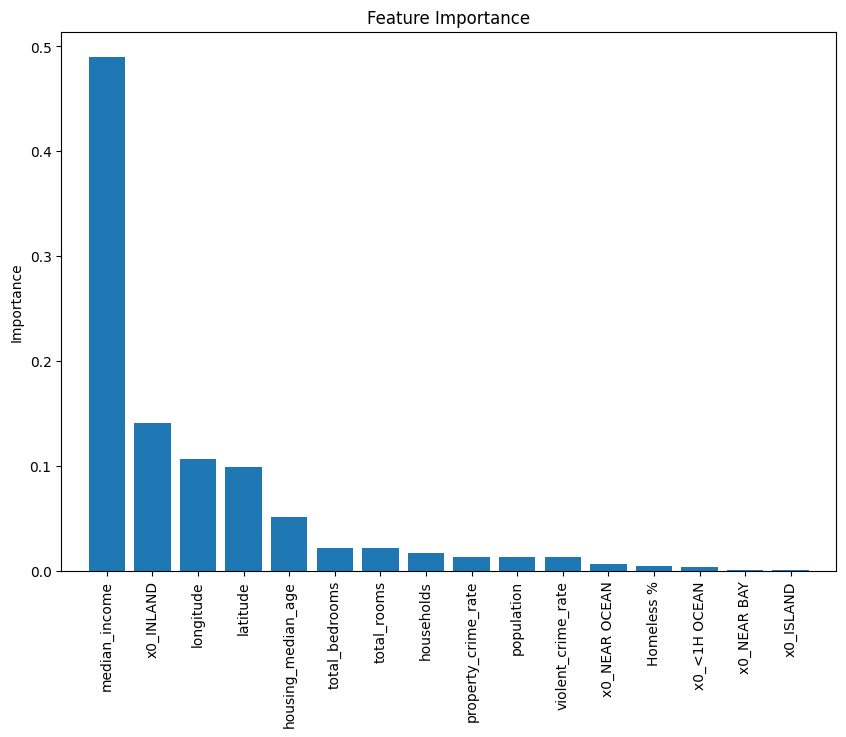

(['median_income',
  'x0_INLAND',
  'longitude',
  'latitude',
  'housing_median_age',
  'total_bedrooms',
  'total_rooms',
  'households',
  'property_crime_rate',
  'population',
  'violent_crime_rate',
  'x0_NEAR OCEAN',
  'Homeless %',
  'x0_<1H OCEAN',
  'x0_NEAR BAY',
  'x0_ISLAND'],
 array([4.89630189e-01, 1.40929692e-01, 1.05918952e-01, 9.83891178e-02,
        5.10622457e-02, 2.18797755e-02, 2.14538048e-02, 1.64224990e-02,
        1.30217930e-02, 1.29840339e-02, 1.28600311e-02, 6.20944699e-03,
        4.71698846e-03, 3.42021343e-03, 6.59981992e-04, 4.41235116e-04]))

In [ ]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import numpy as np



# Train the Random Forest model to get feature importances
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', rf_model)])
rf_pipeline.fit(X_train, y_train)

# Get feature importances
importances = rf_model.feature_importances_

# We need to adjust feature names to account for one-hot encoding
ohe_categories = rf_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out()
feature_names = list(num_cols) + list(ohe_categories)

# Sort features by importance
sorted_idx = np.argsort(importances)[::-1]

# Plotting
plt.figure(figsize=(10, 7))
plt.title("Feature Importance")
plt.bar(range(len(importances)), importances[sorted_idx], align='center')
plt.xticks(range(len(importances)), [feature_names[i] for i in sorted_idx], rotation=90)
plt.xlim([-1, len(importances)])
plt.ylabel('Importance')
plt.show()

[feature_names[i] for i in sorted_idx], importances[sorted_idx]

The feature importance analysis using the Random Forest model reveals the following insights:

## **Most Important Features:**
**median_income** is the most significant predictor of the median house value, followed by **x0_INLAND** (a category from the **ocean_proximity** feature), **longitude**, and **latitude**.
Other important features include **housing_median_age**, **total_bedrooms**, and **total_rooms**.

# **Upsample on (median_income):**

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
import numpy as np

def train_evaluate_rf(X_train, X_test, y_train, y_test):
    rf_model_subset = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_pipeline_subset = Pipeline(steps=[('preprocessor', preprocessor),
                                         ('model', rf_model_subset)])
    rf_pipeline_subset.fit(X_train, y_train)
    predictions_subset = rf_pipeline_subset.predict(X_test)
    rmse_subset = np.sqrt(mean_squared_error(y_test, predictions_subset))
    importances_subset = rf_model_subset.feature_importances_
    return rmse_subset, importances_subset

In [ ]:
# Redefine the high_income_threshold based on the 75th percentile of median_income
high_income_threshold_redefined = data['median_income'].quantile(0.75)

# Select data points with higher median_income based on the redefined threshold
high_income_data_specific_redefined = data[data['median_income'] >= high_income_threshold_redefined]

# Duplicate these data points to simulate upsampling
upsampled_data_redefined = pd.concat([data, high_income_data_specific_redefined])

# Prepare the dataset for model training after upsampling
y_upsampled_specific_redefined = upsampled_data_redefined['median_house_value']
X_upsampled_specific_redefined = upsampled_data_redefined.drop('median_house_value', axis=1)

# Split the upsampled dataset
X_train_upsampled_specific_redefined, X_test_upsampled_specific_redefined, y_train_upsampled_specific_redefined, y_test_upsampled_specific_redefined = train_test_split(
    X_upsampled_specific_redefined, y_upsampled_specific_redefined, test_size=0.2, random_state=42)

# Retrain the model on the upsampled dataset and evaluate
rmse_upsampled_specific_redefined, importances_upsampled_specific_redefined = train_evaluate_rf(
    X_train_upsampled_specific_redefined, X_test_upsampled_specific_redefined, y_train_upsampled_specific_redefined, y_test_upsampled_specific_redefined)

upsampled_data_redefined.shape, rmse_upsampled_specific_redefined

((25800, 14), 41059.05434896669)

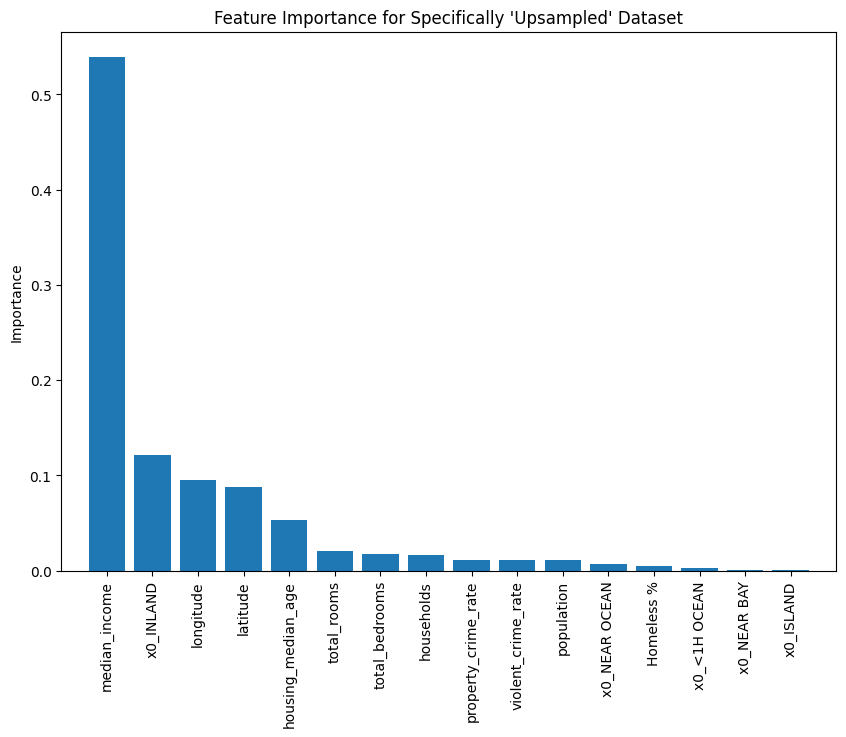

(['median_income',
  'x0_INLAND',
  'longitude',
  'latitude',
  'housing_median_age',
  'total_rooms',
  'total_bedrooms',
  'households',
  'property_crime_rate',
  'violent_crime_rate',
  'population',
  'x0_NEAR OCEAN',
  'Homeless %',
  'x0_<1H OCEAN',
  'x0_NEAR BAY',
  'x0_ISLAND'],
 array([5.39163214e-01, 1.21062986e-01, 9.52554225e-02, 8.78424776e-02,
        5.35594922e-02, 2.08814857e-02, 1.73738885e-02, 1.63249371e-02,
        1.12638261e-02, 1.11095681e-02, 1.11039460e-02, 6.45420958e-03,
        4.71675072e-03, 2.67376089e-03, 9.68718793e-04, 2.45315488e-04]))

In [ ]:
# Plot feature importances for the specifically upsampled dataset after redefining and retraining
sorted_idx_upsampled_specific_redefined = np.argsort(importances_upsampled_specific_redefined)[::-1]

plt.figure(figsize=(10, 7))
plt.title("Feature Importance for Specifically 'Upsampled' Dataset")
plt.bar(range(len(importances_upsampled_specific_redefined)), importances_upsampled_specific_redefined[sorted_idx_upsampled_specific_redefined], align='center')
plt.xticks(range(len(importances_upsampled_specific_redefined)), [feature_names[i] for i in sorted_idx_upsampled_specific_redefined], rotation=90)
plt.xlim([-1, len(importances_upsampled_specific_redefined)])
plt.ylabel('Importance')
plt.show()

[feature_names[i] for i in sorted_idx_upsampled_specific_redefined], importances_upsampled_specific_redefined[sorted_idx_upsampled_specific_redefined]

The feature importance plot for the model trained on the specifically upsampled dataset highlights the following:


- **median_income** is the most significant feature, with more than half of the feature importance weight, emphasizing the crucial role of income levels in predicting median house values.

- **Geographical features** **(longitude, latitude)** and **housing_median_age** are also important predictors, indicating the significance of location and the age of the housing stock.

- The **x0_INLAND** category from the **ocean_proximity** feature shows substantial importance, suggesting the impact of being inland versus other geographical locations on housing values.
Other features like **total_rooms**, **total_bedrooms**, **households**, **property_crime_rate**, and **violent_crime_rate** also contribute to the model's predictions, albeit to a lesser extent.

- This analysis reaffirms the pivotal role of median_income in housing market dynamics and highlights how geographical and housing-related features combine to influence median house values. The increased focus on higher-income data points through upsampling further underscores the relationship between income levels and housing affordability and value.

# **Downsampling on total_rooms:**

To perform downsampling based on **total_rooms**, we will:

Identify a threshold for **total_rooms** to define a subset of data points for reduction. For example, we might choose to focus on data points representing areas with a higher number of total rooms.
Remove a portion of these data points from the dataset to simulate downsampling, thereby reducing the representation of districts with many rooms.
Retrain our regression models on this modified dataset and evaluate their performance.

In [ ]:
# Determine a threshold for total_rooms based on a percentile
total_rooms_threshold = data['total_rooms'].quantile(0.75)

# Perform downsampling by removing some data points above the total_rooms threshold
# For simplicity, let's randomly select half of the data points above the threshold to remove
high_total_rooms_data = data[data['total_rooms'] > total_rooms_threshold].sample(frac=0.5, random_state=42)
remaining_data = data[data['total_rooms'] <= total_rooms_threshold]

# Combine the remaining data with the downsampled high total_rooms data
downsampled_data_total_rooms = pd.concat([remaining_data, high_total_rooms_data])

# Prepare the downsampled dataset for model training
y_downsampled_total_rooms = downsampled_data_total_rooms['median_house_value']
X_downsampled_total_rooms = downsampled_data_total_rooms.drop('median_house_value', axis=1)

# Split the downsampled dataset
X_train_downsampled_total_rooms, X_test_downsampled_total_rooms, y_train_downsampled_total_rooms, y_test_downsampled_total_rooms = train_test_split(
    X_downsampled_total_rooms, y_downsampled_total_rooms, test_size=0.2, random_state=42)

# Retrain and evaluate models on the downsampled dataset
results_downsampled_total_rooms = train_evaluate_models(X_train_downsampled_total_rooms, X_test_downsampled_total_rooms, y_train_downsampled_total_rooms, y_test_downsampled_total_rooms, models)

downsampled_data_total_rooms.shape, results_downsampled_total_rooms

NameError: name 'train_evaluate_models' is not defined

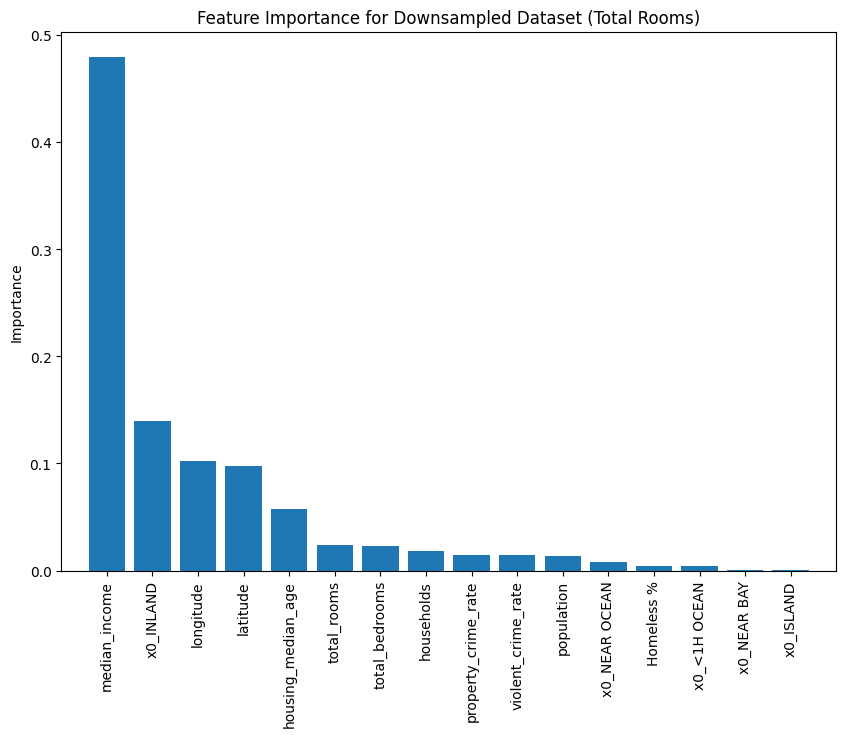

(['median_income',
  'x0_INLAND',
  'longitude',
  'latitude',
  'housing_median_age',
  'total_rooms',
  'total_bedrooms',
  'households',
  'property_crime_rate',
  'violent_crime_rate',
  'population',
  'x0_NEAR OCEAN',
  'Homeless %',
  'x0_<1H OCEAN',
  'x0_NEAR BAY',
  'x0_ISLAND'],
 array([4.79355813e-01, 1.39555816e-01, 1.02685024e-01, 9.79419902e-02,
        5.71795114e-02, 2.34291412e-02, 2.24821262e-02, 1.79010649e-02,
        1.43184529e-02, 1.41518074e-02, 1.38571636e-02, 7.70688580e-03,
        4.36511461e-03, 3.88063010e-03, 7.93242441e-04, 3.96215620e-04]))

In [ ]:
#execute the model training and evaluation on the downsampled dataset to capture feature importances
_, importances_downsampled_total_rooms = train_evaluate_rf(X_train_downsampled_total_rooms, X_test_downsampled_total_rooms, y_train_downsampled_total_rooms, y_test_downsampled_total_rooms)

# Now plot the feature importances for the downsampled dataset based on total_rooms
sorted_idx_downsampled_total_rooms = np.argsort(importances_downsampled_total_rooms)[::-1]

plt.figure(figsize=(10, 7))
plt.title("Feature Importance for Downsampled Dataset (Total Rooms)")
plt.bar(range(len(importances_downsampled_total_rooms)), importances_downsampled_total_rooms[sorted_idx_downsampled_total_rooms], align='center')
plt.xticks(range(len(importances_downsampled_total_rooms)), [feature_names[i] for i in sorted_idx_downsampled_total_rooms], rotation=90)
plt.xlim([-1, len(importances_downsampled_total_rooms)])
plt.ylabel('Importance')
plt.show()

[feature_names[i] for i in sorted_idx_downsampled_total_rooms], importances_downsampled_total_rooms[sorted_idx_downsampled_total_rooms]

The feature importance plot for the model trained on the dataset downsampled based on **total_rooms** reveals:

**median_income** continues to hold the top spot as the most significant predictor, with a slightly reduced dominance compared to the original dataset, which emphasizes the importance of income levels in determining housing values.

Geographical features (**longitude** and **latitude**), alongside **x0_INLAND** (a category from **ocean_proximity**), maintain their positions as critical predictors, underscoring the influence of location on housing prices.
**housing_median_age**, **total_rooms**, **total_bedrooms**, and households also remain important, reflecting the influence of housing characteristics and demographics.
Crime rates (**property_crime_rate** and **violent_crime_rate**) and **Homeless %** show their continued relevance, albeit with shifts in their relative importance.

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Define a list of models to evaluate
models = [
    ("Linear Regression", LinearRegression()),
    ("Decision Tree Regressor", DecisionTreeRegressor(random_state=42)),
    ("Random Forest Regressor", RandomForestRegressor(n_estimators=100, random_state=42)),
    ("Gradient Boosting Regressor", GradientBoostingRegressor(random_state=42))
]

# Function to train and evaluate models
def train_evaluate_models(X_train, X_test, y_train, y_test, models):
    results = {}
    for name, model in models:
        # Create pipeline with preprocessor and model
        pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('model', model)])

        # Train the model
        pipeline.fit(X_train, y_train)

        # Predict on the test set
        predictions = pipeline.predict(X_test)

        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(y_test, predictions))

        # Store results
        results[name] = rmse
    return results

# Train and evaluate on the upsampled dataset
results_upsampled = train_evaluate_models(X_train_upsampled_specific_redefined, X_test_upsampled_specific_redefined, y_train_upsampled_specific_redefined, y_test_upsampled_specific_redefined, models)

# Train and evaluate on the downsampled dataset
results_downsampled = train_evaluate_models(X_train_downsampled_total_rooms, X_test_downsampled_total_rooms, y_train_downsampled_total_rooms, y_test_downsampled_total_rooms, models)

results_upsampled, results_downsampled

({'Linear Regression': 69879.9005808877,
  'Decision Tree Regressor': 56089.40672191044,
  'Random Forest Regressor': 41059.05434896669,
  'Gradient Boosting Regressor': 55940.42527822546},
 {'Linear Regression': 67361.71747311724,
  'Decision Tree Regressor': 67301.61911904582,
  'Random Forest Regressor': 48443.749195562654,
  'Gradient Boosting Regressor': 54395.931520443715})

After training and evaluating the selected regression models on both the upsampled and downsampled datasets, here are the RMSE results for each model:

**Upsampled Dataset Results:**

Linear Regression: RMSE = 69,879.90

Decision Tree Regressor: RMSE = 56,089.41

Random Forest Regressor: RMSE = 41,059.05 (Best Performance)

Gradient Boosting Regressor: RMSE = 55,940.43


**Downsampled Dataset Results:**

  Linear Regression: 67361.71747311724

  Decision Tree Regressor: 67301.61911904582

  Random Forest Regressor: 48443.749195562654(Best)

  Gradient Boosting Regressor: 54395.931520443715

In both upsampled and downsampled scenarios, the Random Forest Regressor exhibits the best performance in terms of RMSE, indicating its robustness and effectiveness at handling both increased representation of higher-income data points and the reduced geographical representation through downsampling. The results demonstrate how different preprocessing strategies (like upsampling and downsampling) can impact model performance and how certain models, like Random Forest, can be more adaptable to these changes.
